Table of contents
1. [Precinct Shapefile](#shapefile)
2. [Election Results](#electionresults)
3. [Joining Election Results to Precinct Shapefile](#joining)
4. [Comparison to VEST](#comparison)

**Import Python Packages**

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopandas as gp
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

<a name="shapefile"></a>


# Precinct Shapefile

## Load VEST's Final File

VEST's documentation file: 

Michigan

Election results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)
Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map.

Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

Detroit allows for absentee votes to be reported by Absentee Voter Counting Boards, which generally contain multiple precincts. These votes are apportioned to precincts by candidate in the same shares that the non-AVCB vote was split among precincts within a county. The linkage between election precinct and AVCB was provided by OpenElections via Derek Willis. Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

G16PREDCli - Hillary Clinton (Democratic Party)
G16PRERTru - Donald J. Trump (Republican Party)
G16PREGSte - Jill Stein (Green Party)
G16PRELJoh - Gary Johnson (Libertarian Party)
G16PREOth - Other Candidates/Write-in Votes

In [2]:
vest_shp = gp.read_file("./raw-from-source/mi_2016/mi_2016.shp")

In [3]:
vest_shp.shape

(4810, 8)

In [4]:
vest_shp.head(1)

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
0,1632100000001,City of Dearborn,581,93,17,11,1,"POLYGON ((-83.14843 42.34469, -83.14861 42.343..."


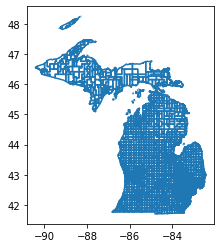

In [5]:
vest_shp.boundary.plot()

## Load Source Precinct File

In [6]:
precincts = gp.read_file("./raw-from-source/2016_Voting_Precincts/2016_Voting_Precincts.shp")

In [7]:
precincts.shape

(4810, 10)

In [8]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."


The jurisdiction may be MCD (minor civil division) FIPS code from 2016?

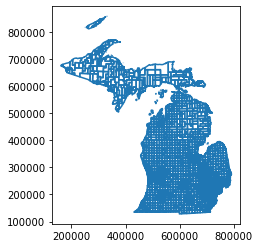

In [9]:
precincts.boundary.plot()

<a name="electionresults"></a>


# Election Results

## Loading SOS Results

In [10]:
mi_elections = pd.read_csv('./raw-from-source/2016GEN/2016vote.txt', delimiter = '\t', header = None)

Columns are defined in the `readme.txt` file

In [13]:
mi_elections.columns = ['election_year','election_type','office_code','district_code',
                                     'status_code','candidate_id','county_code','city_town_code','ward_number',
                                     'precinct_number','precinct_label','precinct_votes','na_col']

In [14]:
mi_elections

,election_year,election_type,office_code,district_code,status_code,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,precinct_votes,na_col
0,2016,GEN,0,0,0,0,1,2,0,1,NaN,725,NaN
1,2016,GEN,0,0,0,0,1,4,0,1,NaN,652,NaN
2,2016,GEN,0,0,0,0,1,6,0,1,NaN,647,NaN
3,2016,GEN,0,0,0,0,1,8,0,1,NaN,796,NaN
4,2016,GEN,0,0,0,0,1,10,0,1,NaN,360,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337240,2016,GEN,13,0,2,517917,83,32,0,1,NaN,83,NaN
337241,2016,GEN,13,0,2,517917,83,52,0,1,NaN,174,NaN
337242,2016,GEN,13,0,2,517917,83,52,0,2,NaN,234,NaN
337243,2016,GEN,13,0,2,517917,83,52,0,3,NaN,271,NaN


In [62]:
mi_elections[(mi_elections.county_code == 2) & ((mi_elections.city_town_code == 52) | (mi_elections.city_town_code == 12))]

,election_year,election_type,office_code,district_code,status_code,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,precinct_votes,na_col
5059,2016,GEN,1,0,0,-1142,2,12,0,1,,0,NaN
5060,2016,GEN,1,0,0,-1142,2,12,0,2,,0,NaN
5063,2016,GEN,1,0,0,-1142,2,52,0,1,,0,NaN
10136,2016,GEN,1,0,0,-1141,2,12,0,1,,0,NaN
10137,2016,GEN,1,0,0,-1141,2,12,0,2,,0,NaN
10140,2016,GEN,1,0,0,-1141,2,52,0,1,,0,NaN
15213,2016,GEN,1,0,0,-1140,2,12,0,1,,0,NaN
15214,2016,GEN,1,0,0,-1140,2,12,0,2,,0,NaN
15217,2016,GEN,1,0,0,-1140,2,52,0,1,,0,NaN
20290,2016,GEN,1,0,0,-1139,2,12,0,1,,0,NaN


Filter to office code `1` for president

In [15]:
mi_elections = mi_elections[mi_elections['office_code'] == 1]

In [16]:
mi_elections.groupby('candidate_id')['precinct_votes'].sum()

candidate_id
-1142         95
-1141        517
-1140         30
-1139       8177
-1137         87
-1136         39
-1135         10
-1130      51463
-1128    2268839
-1112       2209
-1110    2279543
-1108      16139
-1101     172136
Name: precinct_votes, dtype: int64

Compare to VEST results

In [17]:
vest_shp[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64

Using the file `2016name.txt` to figure out these candidate codes: 
- -1130    Stein
- -1128    Clinton
- -1110    Trump
- -1101    Johnson

## Pivot SOS Results

Have to replace NaNs in `precinct_label` with empty strings so that we can use it as an index in the pivot

In [18]:
mi_elections['precinct_label'] = mi_elections['precinct_label'].replace(np.nan, '', regex = True)

<ipython-input-18-181b89ef09b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_elections['precinct_label'] = mi_elections['precinct_label'].replace(np.nan, '', regex = True)


In [19]:
mi_elections_pivot = mi_elections.pivot_table(index = ['county_code','city_town_code','precinct_number','precinct_label'],
                         columns = ['candidate_id'],
                        values = ['precinct_votes'],
                         aggfunc = 'sum')

In [20]:
mi_elections_pivot[('precinct_votes',-1128)].sum()

2268839

In [21]:
mi_elections_pivot.shape

(4967, 13)

Testing out dataset, investigating

In [22]:
mi_elections_pivot.reset_index(inplace = True)

In [23]:
mi_elections_pivot.columns

MultiIndex([(    'county_code',    ''),
            ( 'city_town_code',    ''),
            ('precinct_number',    ''),
            ( 'precinct_label',    ''),
            ( 'precinct_votes', -1142),
            ( 'precinct_votes', -1141),
            ( 'precinct_votes', -1140),
            ( 'precinct_votes', -1139),
            ( 'precinct_votes', -1137),
            ( 'precinct_votes', -1136),
            ( 'precinct_votes', -1135),
            ( 'precinct_votes', -1130),
            ( 'precinct_votes', -1128),
            ( 'precinct_votes', -1112),
            ( 'precinct_votes', -1110),
            ( 'precinct_votes', -1108),
            ( 'precinct_votes', -1101)],
           names=[None, 'candidate_id'])

In [24]:
vote_cols_other = [( 'precinct_votes', -1142),
            ( 'precinct_votes', -1141),
            ( 'precinct_votes', -1140),
            ( 'precinct_votes', -1139),
            ( 'precinct_votes', -1137),
            ( 'precinct_votes', -1136),
            ( 'precinct_votes', -1135),
            ( 'precinct_votes', -1112),
            ( 'precinct_votes', -1108)]
mi_elections_pivot['G16PREOth'] = 0
for col in vote_cols_other:
    mi_elections_pivot['G16PREOth'] = mi_elections_pivot['G16PREOth'] + mi_elections_pivot[col]
    mi_elections_pivot.drop(col[1], axis = 1, level = 1, inplace = True)

In [25]:
mi_elections_pivot.head()

county_code city_town_code precinct_number precinct_label  \
candidate_id                                                             
0                      1              2               1                  
1                      1              4               1                  
2                      1              6               1                  
3                      1              8               1                  
4                      1             10               1                  

             precinct_votes                   G16PREOth  
candidate_id          -1130 -1128 -1110 -1101            
0                         2   199   500    13         4  
1                         4   178   441    14         5  
2                        13   214   401     8         3  
3                         4   256   501    22         2  
4                         6    80   249    16         1

In [26]:
mi_elections_pivot.reset_index(inplace = True)

In [27]:
mi_elections_pivot.columns = ['candidate_id','county_code','city_town_code','precinct_number','precinct_label',
                              'G16PREGSte','G16PREDCli','G16PRERTru','G16PRELJoh','G16PREOth']

In [28]:
mi_elections_pivot.head()

,candidate_id,county_code,city_town_code,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth
0,0,1,2,1,,2,199,500,13,4
1,1,1,4,1,,4,178,441,14,5
2,2,1,6,1,,13,214,401,8,3
3,3,1,8,1,,4,256,501,22,2
4,4,1,10,1,,6,80,249,16,1


In [29]:
mi_elections_pivot.drop('candidate_id', axis = 1, inplace = True)

In [30]:
mi_elections_pivot[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64

In [31]:
vest_shp[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64

## Cleaning SOS Results

#### Add County Name

The SOS results have county codes that are not FIPS codes. Pulled the `county.txt` file to a Sheet and lined it up with county fips codes from Wikipedia. Loading in this file created in Sheets. 

In [32]:
county_names = pd.read_csv('./raw-from-source/county_codes.csv', dtype = {'county_fips':'object'})

In [33]:
county_names

,county_code,county_name,county_fips
0,1,ALCONA,001
1,2,ALGER,003
2,3,ALLEGAN,005
3,4,ALPENA,007
4,5,ANTRIM,009
...,...,...,...
78,79,TUSCOLA,157
79,80,VAN BUREN,159
80,81,WASHTENAW,161
81,82,WAYNE,163


In [34]:
county_names.dtypes

county_code     int64
county_name    object
county_fips    object
dtype: object

In [35]:
mi_elections_pivot = mi_elections_pivot.merge(county_names, on = 'county_code')

In [36]:
mi_elections_pivot

,county_code,city_town_code,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips
0,1,2,1,,2,199,500,13,4,ALCONA,001
1,1,4,1,,4,178,441,14,5,ALCONA,001
2,1,6,1,,13,214,401,8,3,ALCONA,001
3,1,8,1,,4,256,501,22,2,ALCONA,001
4,1,10,1,,6,80,249,16,1,ALCONA,001
...,...,...,...,...,...,...,...,...,...,...,...
4962,83,52,1,,25,456,792,53,6,WEXFORD,165
4963,83,52,2,,28,440,800,60,13,WEXFORD,165
4964,83,52,3,,23,498,869,55,9,WEXFORD,165
4965,83,54,1,,5,132,304,27,3,WEXFORD,165


#### Add City/Township Name

Loading in the `2016city.txt` file that has the corresponding names for the city codes in the election results file

In [37]:
city_codes = pd.read_csv('./raw-from-source/2016GEN/2016city.txt',delimiter='\t',header=None)

In [38]:
city_codes.columns = ['election_year','election_type','county_code','city_town_code','city_town_name','null']

In [39]:
city_codes.drop(['election_year','election_type','null'],axis=1,inplace=True)

In [40]:
city_codes.head()

,county_code,city_town_code,city_town_name
0,1,2,ALCONA TOWNSHIP
1,1,4,CALEDONIA TOWNSHIP
2,1,6,CURTIS TOWNSHIP
3,1,8,GREENBUSH TOWNSHIP
4,1,10,GUSTIN TOWNSHIP


In [41]:
mi_elections_pivot = mi_elections_pivot.merge(city_codes, on = ['county_code','city_town_code'])

In [42]:
mi_elections_pivot.head()

,county_code,city_town_code,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name
0,1,2,1,,2,199,500,13,4,ALCONA,001,ALCONA TOWNSHIP
1,1,4,1,,4,178,441,14,5,ALCONA,001,CALEDONIA TOWNSHIP
2,1,6,1,,13,214,401,8,3,ALCONA,001,CURTIS TOWNSHIP
3,1,8,1,,4,256,501,22,2,ALCONA,001,GREENBUSH TOWNSHIP
4,1,10,1,,6,80,249,16,1,ALCONA,001,GUSTIN TOWNSHIP


# Merging

In [43]:
precincts.to_csv('precincts.csv')

In [44]:
mi_elections_pivot.to_csv('mi_elections_pivot.csv')

The VEST documentation says to merge Fremont and Richmond but took a look at the files in Excel and could not figure out what they merged. Will try joining and come back to this. 

<a name="joining"></a>


# Joining Election Results

## Join Attempt #1

In [45]:
mi_elections_pivot.head(5)

,county_code,city_town_code,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name
0,1,2,1,,2,199,500,13,4,ALCONA,001,ALCONA TOWNSHIP
1,1,4,1,,4,178,441,14,5,ALCONA,001,CALEDONIA TOWNSHIP
2,1,6,1,,13,214,401,8,3,ALCONA,001,CURTIS TOWNSHIP
3,1,8,1,,4,256,501,22,2,ALCONA,001,GREENBUSH TOWNSHIP
4,1,10,1,,6,80,249,16,1,ALCONA,001,GUSTIN TOWNSHIP


In [46]:
mi_elections_pivot.shape

(4967, 12)

In [47]:
mi_elections_pivot[(mi_elections_pivot.city_town_name != "{Statistical Adjustments}")].shape

(4911, 12)

In [48]:
mi_elections_pivot[(mi_elections_pivot.city_town_name != "{Statistical Adjustments}") \
                  & ~((mi_elections_pivot.city_town_name == "DETROIT CITY") & (mi_elections_pivot.precinct_label == "AVCB"))].shape

(4739, 12)

In [49]:
precincts.head(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."


In [50]:
precincts.shape

(4810, 10)

Looks like this is only needed for Apache County, so we'll deal with it later

Remove 'County' from county_name in election results

In [51]:
mi_elections_pivot['county'] = mi_elections_pivot['county_name'].str.replace(' County','')

In [56]:
mi_elections_pivot.sample(5)

,county_code,city_town_code,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county
1097,33,54,3,,12,613,407,47,10,INGHAM,065,LANSING CITY,INGHAM
3479,74,44,901,AVCB,4,231,500,19,0,ST. CLAIR,147,ST. CLAIR TOWNSHIP,ST. CLAIR
537,22,4,2,,7,207,601,40,3,DICKINSON,043,BREITUNG TOWNSHIP,DICKINSON
2694,63,30,1,,20,455,815,74,2,OAKLAND,125,ORION TOWNSHIP,OAKLAND
1510,41,40,2,,14,254,599,43,3,KENT,081,TYRONE TOWNSHIP,KENT


In [60]:
mi_elections_pivot['county_fips'].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165'], dtype=object)

In [59]:
precincts.sample(2)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
3732,3733,4316,1632200005439,163,22000,2016,City of Detroit,1.084227e+06,4933.674538,"POLYGON ((738538.692 208037.102, 738558.480 20..."
24,25,3913,1632100000026,163,21000,2016,City of Dearborn,1.366077e+06,4698.249627,"POLYGON ((729042.172 196536.828, 728994.204 19..."


In [61]:
precincts['CountyFips'].unique()

array(['163', '001', '003', '005', '007', '009', '011', '013', '015',
       '017', '019', '021', '023', '025', '027', '029', '031', '033',
       '035', '037', '039', '041', '043', '045', '047', '049', '051',
       '053', '055', '057', '059', '061', '063', '065', '067', '069',
       '071', '073', '075', '077', '079', '081', '083', '085', '087',
       '089', '091', '093', '095', '097', '099', '101', '103', '105',
       '107', '109', '111', '113', '115', '117', '119', '121', '123',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '165', '125'], dtype=object)

In [ ]:
df_joined = precincts.merge(mi_elections_pivot, how = 'outer'
                            , left_on = ['CountyFips','PRECINCTNA'], right_on = ['county_fips','precinct']
                            , indicator = True)

In [ ]:
df_joined.groupby('_merge').count()

Lily's going to ask Brian for the translation for AVCB/Detroit translation for 2016. 

Lily Falk to Everyone (11:52 AM)
“WP-” + three digit county FIPs code + “-” + five digit MCD FIPs code + two digit ward code + 3 digit precinct code
Ex: WP-001-01040-00001
Lily Falk to Everyone (11:53 AM)
Three digit county FIPs code + “-” + City/Town Name + “-” + one digit ward code + “-0” + three digit precinct code
Ex: 001-ALCONA TOWNSHIP-0-0001